In [2]:
import numpy as np
import matplotlib.pyplot as plt

from wave_fracture_HT15_interactive import *

In [ ]:
## User settings and aesthetics
plot_accent_color = 'tab:red'

### Default parameters from Icepack
```
     real (kind=dbl_kind), parameter  :: &
         swh_minval = 0.01_dbl_kind,  & ! minimum value of wave height (m)
         straincrit = 3.e-5_dbl_kind, & ! critical strain
!         D          = 1.e4_dbl_kind,  & ! domain size
         dx         = c1,             & ! domain spacing
         threshold  = c10               ! peak-finding threshold -
                                        ! points are defined to be extrema if they
                                        ! are a local max or min over a distance
                                        ! of 10m on both sides, based on the
                                        ! observations of Toyota et al. (2011) who
                                        ! find this to be the order of the smallest
                                        ! floe size affected by wave fracture

      integer (kind=int_kind), parameter, public :: &
         nx = 10000         ! number of points in domain

      integer (kind=int_kind), parameter :: &
         max_no_iter = 100 ! max no of iterations to compute wave fracture
```

In [9]:
swh_minval = 0.01  # minimum value of wave height (m)
straincrit = 3.5e-5  # critical strain for fracture
D = 1.e4 # Domain size in m
dx = 1.0 # Domain spacing
threshold = 10 # Peak finding theshold
nx = 1000 # Number of grid points
max_no_iter = 100 # Maximum number of iterations

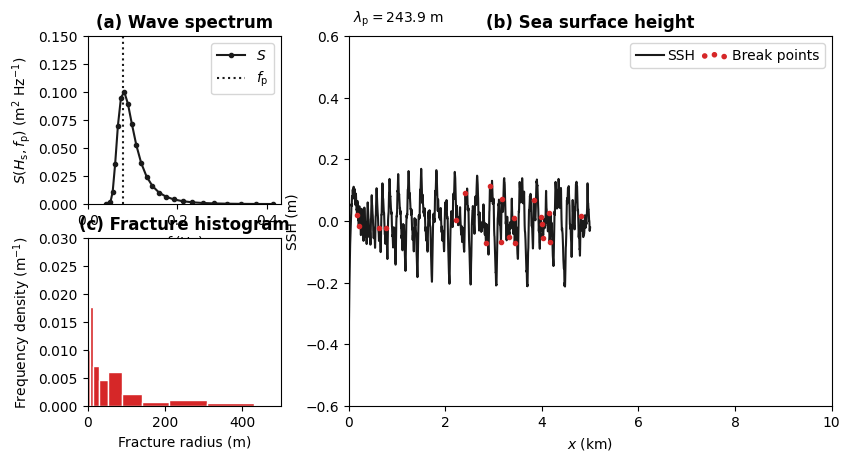

In [7]:
# ----------------------------------------------------------------------- #
# Calculate initial data
# ======================================================================= #

# Calculate all required fields from initial values of sliders; these will
# be used as global variables in the functions to update plots via widgets:

data_wfreq, data_wdfreq = wfreq(slider_opts["nf"][0][1], slider_opts["f0"][0][1],
                                slider_opts["kf"][0][1])

data_is_mono = False
data_wspec   = wspec_bret(slider_opts["hs"][0][1] , slider_opts["fp"][0][1], data_wfreq)
data_x1d     = x1d(slider_opts["xmax"][0][1]*1000., slider_opts["dx"][0][1])
data_x1d_km  = data_x1d * 1.e-3

# Create phases for maximum number of frequencies selectable, so even if parameter nf
# (number of frequencies) changes we still do not need to calculate random phases again
# (initially, phases are fixed):
nf_max      = slider_opts["nf"][0][2]
data_phase  = phase_init * np.ones(nf_max)
data_ssh    = ssh(data_x1d, data_wfreq, data_wdfreq, data_wspec, data_phase)

data_breaks = calc_break_locs(data_x1d, data_ssh,
                                rmin_in=slider_opts["rmin"][0][1],
                                dx_in  =slider_opts["dx"  ][0][1],
                                hi_in  =slider_opts["hi"  ][0][1],
                                ec_in  =slider_opts["ec"  ][0][1] * ec_0)

data_frac_radii = calc_frac_radii(data_x1d, data_breaks)
data_frac_hist  = calc_frac_histogram(data_frac_radii)


# ----------------------------------------------------------------------- #
# Set up figure with initial plots
# ======================================================================= #

fig = plt.figure(figsize=(9.6, 4.8))
fig.canvas.manager.set_window_title("Wave Fracture")
axd = fig.subplot_mosaic("AB;CB", width_ratios=[1.,2.5])

line_wspec, = axd["A"].plot(data_wfreq, data_wspec, color=plot_line_color,
                            marker="o", ms=plot_marker_size, label=r"$S$")

line_fp     = axd["A"].axvline([slider_opts["fp"][0][1]], linestyle=":",
                                color=plot_line_color, label=r"$f_\mathrm{p}$")

line_ssh,   = axd["B"].plot(data_x1d_km, data_ssh, color=plot_line_color,
                            label="SSH", zorder=1)

sctr_break  = axd["B"].scatter(data_x1d_km[data_breaks], data_ssh[data_breaks],
                                color=plot_accent_color, s=plot_marker_size**2,
                                label="Break points", zorder=2)

hist_bin_widths = hist_bins[1:] - hist_bins[:-1]

bar_frac    = axd["C"].bar(hist_bins[:-1], data_frac_hist, width=hist_bin_widths,
                            align="edge", facecolor=plot_accent_color, edgecolor="w")

axd["A"].set_xlim(xmin=0.)
axd["A"].set_ylim(0., .15)
axd["A"].set_xlabel(r"$f$ (Hz)")
axd["A"].set_ylabel(r"$S(H_\mathrm{s},f_\mathrm{p})$ (m$^2$ Hz$^{-1}$)")
axd["A"].set_title("(a) Wave spectrum", fontweight="bold")
axd["A"].legend(loc="upper right")

axd["B"].set_xlim(0., slider_opts["xmax"][0][2])
axd["B"].set_ylim(-.6, .6)
axd["B"].set_xlabel(r"$x$ (km)")
axd["B"].set_ylabel(r"SSH (m)")
axd["B"].set_title("(b) Sea surface height", fontweight="bold")
axd["B"].legend(loc="upper right", ncols=2, columnspacing=.4, handletextpad=.25, scatterpoints=3)

ssh_text = axd["B"].annotate(r"$\lambda_\mathrm{p}=%.1f$ m" % wlam(slider_opts["fp"][0][1]),
                                (.01, 1.02), ha="left", va="bottom", xycoords="axes fraction")

axd["C"].set_xlim(0., 500.)
axd["C"].set_ylim(0., .03)
axd["C"].set_xlabel(r"Fracture radius (m)")
axd["C"].set_ylabel(r"Frequency density (m$^{-1}$)")
axd["C"].set_title("(c) Fracture histogram", fontweight="bold")

for k in axd.keys():
    axd[k].set_label(axd[k].get_title())
